# Trabajo Práctico 1

In [ ]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
import pyproj
import shapely.wkt
import numpy as np

 # Glosario columnas

-  operation: tipo de operacion (venta)
-  property type: tipo de propiedad (house, PH, apartment, store)
-  place_name: localidad de la propiedad.
-  place_with_parent_names: localidad junto a provinca, pais.
-  country_name: pais donde se encuentra la propiedad.
-  state_name: provincia donde se encuentra la propiedad.
-  geonames_id: número de identificación en la base de datos GeoNames.
-  lat-lon: latitud y longitud juntos.
-  lat: latidud.
-  lon: longitud.
-  price: precio de la propiedad en relacion a su moneda.
-  currency: moneda en la que se encuentra valorizada la propiedad.
-  price_aprox_local_currency: precio aproximado en pesos de la propiedad.
-  price_aprox_usd: precio aproximado del inmueble en dólares.
-  surface_total_in_m2: superficie total del inmueble en metros cuadrados.
-  surface_covered_in_m2: superficie cubierta del inmueble en metros cuadrados.
-  price_usd_per_m2: precio en dólares del metro cuadrado vs total m2.
-  price_per_m2: precio, no se sabe en qué moneda.
-  floor: piso? no es claro, valores extraños.
-  rooms: cantidad de habitaciones.
-  expenses: valor de las expensas.
-  properati_url: url de la url de properati donde está publicado el inmueble.
-  description: descripción completa de todo el inmueble. Contiene información de todas las columnas y más.
-  title: título con el que se encuentra publicado. Aparece el tipo de propiedad, zona y alguna característica destacada como cantidad de ambientes.
-  image_thumbnail: fotos del inmueble.

# Leemos el dataset

In [ ]:
data=pd.read_csv('./properatti.csv')

# Observamos las diferentes columnas, los tipos de datos y cuantos valores no nulos tienen


In [ ]:
data.info()

In [ ]:
#El metodo describe arroja principalmente estadisticas descriptivas para columnas con datos cuantitativos, es por ello que vemos tan solo 14 columnas del dataset
data.describe()

In [ ]:
#Tomamos una muestra para entender los valores del dataset
data.sample(10)

# EDA (Exploration Data Analysis)

## Porcentaje por columna


In [ ]:
#Porcentaje de nulls respecto al total del dataset por columna

percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

In [ ]:
# Verificamos que todas las operaciones sean de tipo "Venta" // Podemos descartar esta columna
data.operation.value_counts()

## Dropeamos (descartamos) la columna operation porque tiene un solo valor

In [ ]:
data.drop('operation',inplace=True, axis=1)

## Análisis columnas económicas

Price, Currency, Price_aprox_usd, Price_aprox_local_currency

Como decisión de negocios, decidimos usar valores de precio en dólares únicamente, por lo que estos son los que intentaremos completar y depurar.

In [ ]:
#Cantidad de casos en que 'price' coincide con 'Price_aprox_usd'. Tenemos 87588 que coinciden.

sum(data.price == data.price_aprox_usd)

87588

In [ ]:
#Cantidad de casos en que 'price' no coincide con 'Price_aprox_usd'. Tenemos 33632 que no coinciden.
sum(data.price != data.price_aprox_usd)

33632

In [ ]:
#Cantidad de casos en que 'price' coincide con 'price_aprox_local_currency'
sum(data.price == data.price_aprox_local_currency)

1

In [ ]:
#Es uno solo, así que veo cuál es:

data[data.price == data.price_aprox_local_currency][['price', 'currency', 'price_aprox_usd', 'price_aprox_local_currency']]

,price,currency,price_aprox_usd,price_aprox_local_currency
9761,0.0,NaN,0.0,0.0


In [ ]:
#Corroboro que todos los 'price' cuya 'currency' es USD se correspondan con el 'price_aprox_usd'

data2 = data[data.currency == 'USD']

In [ ]:
#Valido si hay algun precio que sea distinto
len(data2[data2.price != data2.price_aprox_usd])

0

In [ ]:
#veo que hay uno menos que los coincidentes en valor(87588 vs 87587), alguno debe estar mal etiquetado, lo busco.
len(data2)

87587

In [ ]:
data[(data.price == data.price_aprox_usd) & (data.currency != 'USD')][['price', 'currency', 'price_aprox_usd', 'price_aprox_local_currency']]

,price,currency,price_aprox_usd,price_aprox_local_currency
9761,0.0,NaN,0.0,0.0


In [ ]:
#Ahora analizamos aquellos valores cuyos 'currency' no son USD.
data.currency.value_counts()

USD    87587
ARS    13219
PEN        2
UYU        1
Name: currency, dtype: int64

In [ ]:
data[['price_aprox_usd', 'price']][data.currency == 'PEN']

,price_aprox_usd,price
50387,117139.33,380000.0
50388,292848.33,950000.0


In [ ]:
data[['price_aprox_usd', 'price']][data.currency == 'UYU']

,price_aprox_usd,price
107390,22980378.29,650000000.0


In [ ]:
auxData = data['description']


In [ ]:
auxData = auxData.str.upper()
auxData = auxData.str.replace('.','', regex=True)
auxData.fillna('', inplace = True)
auxData.head()

0    2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...
1    VENTA DE DEPARTAMENTO EN DÉCIMO PISO AL FRENTE...
2    2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...
3    PH 3 AMBIENTES CON PATIO HAY 3 DEPTOS EN LOTE,...
4    DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...
Name: description, dtype: object

In [ ]:
auxData2 = auxData.str.extract('(USD|USS|US|U[$]D|U[$][$]|U[$]S)\s?(\d+)')
auxData2.head

<bound method NDFrame.head of           0      1
0       NaN    NaN
1       U$D  20000
2       NaN    NaN
3       NaN    NaN
4       NaN    NaN
...     ...    ...
121215  NaN    NaN
121216  NaN    NaN
121217  USD  20000
121218  U$S  95900
121219  NaN    NaN

[121220 rows x 2 columns]>

In [ ]:
auxData2.columns=['USD', 'price']

In [ ]:
auxData2.price.notnull().sum()

13039

In [ ]:
#aplico al dataset
auxData2.price = pd.to_numeric(auxData2['price'])

In [ ]:
data['price_aprox_usd'] = data['price_aprox_usd'].fillna(auxData2['price'])

In [ ]:
data['price_aprox_usd'].isnull().sum()

19278

In [ ]:
#regex para tittle
auxData3 = data['title']

In [ ]:
# formateo auxData3 para el regex

auxData3 = auxData3.str.upper()
auxData3 = auxData3.str.replace('.', '', regex=True)
auxData3.fillna('', inplace=True)

In [ ]:
# hago la extracion
auxData4 = auxData3.str.extract('(USD|USS|US|U[$]D|U[$][$]|U[$]S)\s?(\d+)')

In [ ]:
# renombro columnas
auxData4.columns = ['USD', 'price']

In [ ]:
# tenemos 6948 precios que no son nulos
auxData4.price.notnull().sum()

6948

In [ ]:
# paso a numero los precios
auxData4.price = pd.to_numeric(auxData4['price'])

In [ ]:
#Se aplica al dataset
data['price_aprox_usd'] = data['price_aprox_usd'].fillna(auxData4['price'])

In [ ]:
# Todavia tenemos 17102 valores nulos para price
data['price_aprox_usd'].isnull().sum()

17102

In [ ]:
#Completamos hasta ahora 3308 vacíos, quedandonos con 17102 datos vacíos.

ymax: 129629628.45


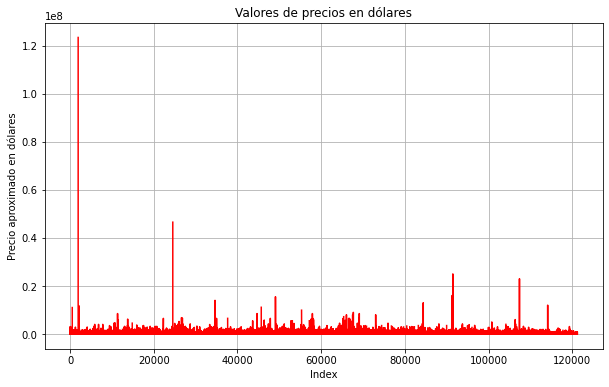

In [ ]:
#Separo valores de precios muy extremos para revaluar con coherencia:

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(data.price_aprox_usd)), data.price_aprox_usd, color='red')

plt.xlabel('Index')
plt.ylabel('Precio aproximado en dólares')
plt.title('Valores de precios en dólares')

xmin, xmax, ymin, ymax = plt.axis()
print('ymax: %.2f'% ymax)

In [ ]:
## precio por m2
data.price_usd_per_m2.describe()

count     68617.000000
mean       2160.086916
std        2759.288621
min           0.600000
25%        1218.181818
50%        1800.000000
75%        2486.411765
max      206333.333333
Name: price_usd_per_m2, dtype: float64

In [ ]:

#Vemos los null
data.price_aprox_usd[data.price_aprox_usd.isnull()].index


Int64Index([     5,     20,     41,     62,     67,     76,     83,     84,
                85,    100,
            ...
            121126, 121127, 121129, 121142, 121207, 121208, 121210, 121211,
            121212, 121213],
           dtype='int64', length=17102)

In [ ]:
len(data.price_aprox_usd[data.price_aprox_usd.isnull()].index)

17102

In [ ]:
indices=data.price_usd_per_m2[data.price_usd_per_m2.isnull()].index
indices

Int64Index([     1,      3,      5,      9,     11,     20,     41,     62,
                65,     67,
            ...
            121152, 121155, 121156, 121207, 121208, 121210, 121211, 121212,
            121213, 121214],
           dtype='int64', length=52603)

In [ ]:
len(data.price_usd_per_m2[data.price_usd_per_m2.isnull()].index)

52603

In [ ]:
data.surface_total_in_m2[data.surface_total_in_m2.isnull()].index


Int64Index([     1,      3,      9,     11,     65,     68,     70,     71,
                72,     77,
            ...
            121148, 121149, 121150, 121151, 121152, 121155, 121156, 121207,
            121208, 121210],
           dtype='int64', length=39328)

In [ ]:
len(data.surface_total_in_m2[data.surface_total_in_m2.isnull()].index)

39328

In [ ]:
price_usd_per_m2_nuevo = data[['price_aprox_usd','surface_total_in_m2']]

price_usd_per_m2_nuevo = pd.DataFrame(price_usd_per_m2_nuevo.apply(lambda x: x['price_aprox_usd']/x['surface_total_in_m2'] 
                                   if(x['price_aprox_usd'] > 0 and x['surface_total_in_m2'] > 0 and x['price_aprox_usd'] > x['surface_total_in_m2']) 
                                   else np.nan, axis=1
                                  )
                     )

In [ ]:
price_usd_per_m2_nuevo

,0
0,1127.272727
1,NaN
2,1309.090909
3,NaN
4,1828.571429
...,...
121215,7699.115044
121216,1383.333333
121217,2858.695652
121218,1997.916667


In [ ]:
price_usd_per_m2_nuevo.mean()


0    2130.800129
dtype: float64

In [ ]:
data.price_usd_per_m2.fillna(price_usd_per_m2_nuevo[0], inplace=True)


In [ ]:
data.price_usd_per_m2.isnull().sum()


50222

Analizamos cómo fueron calculados los valores de precio por m2, para los datos que coinciden precio y precio_aprox_usd:

In [ ]:
#total
data.loc[(data['price'] == data['price_aprox_usd'])].shape

(87588, 26)

In [ ]:
#vacios
data.loc[(data['price'] == data['price_aprox_usd']) & (data['price_aprox_usd'].isnull())].shape

(0, 26)

In [ ]:
#price usd o price y sup total (bien)

data.loc[(data['price'] == data['price_aprox_usd']) & (round(data['price_usd_per_m2'],2) == round((data['price_aprox_usd']/data['surface_total_in_m2']),2))].shape


(60133, 26)

In [ ]:
##price usd o price y sup cubierta

data.loc[(data['price'] == data['price_aprox_usd']) & (round(data['price_usd_per_m2'],2) == round((data['price_aprox_usd']/data['surface_covered_in_m2']),2))].shape


(18400, 26)

Notamos que fueron calculados de diferenctes maneras y que también hay datos erróneos.

En todos los casos, reemplazamos la fórmula por la correcta:

In [ ]:
data.price_usd_per_m2 = np.where((data['price'] != data['price_aprox_usd']) & (data['surface_total_in_m2'] != 0), data['price_aprox_usd']/data['surface_total_in_m2'], data['price_usd_per_m2'])


In [ ]:
data.price_usd_per_m2 = np.where((data['price'] == data['price_aprox_usd'])  & (data['surface_total_in_m2'] != 0), data['price_aprox_usd']/data['surface_total_in_m2'], data['price_usd_per_m2'])


In [ ]:
data.price_usd_per_m2.isnull().sum()


50010

In [ ]:
# Confirmar, se hizo la media y se completaron los nan
data.price_usd_per_m2.fillna(data.groupby(['property_type', 'place_name'])['price_usd_per_m2'].transform('mean'), inplace=True)


In [ ]:
data.price_usd_per_m2.isnull().sum()

1542

## Property Type

In [ ]:
# Vemos 4 valores distintos de property_type. 
# La mayor cantidad de anuncios son de Apartment y House
print(data.property_type.value_counts())
sns.histplot( x="property_type", data=data, hue='property_type' )
plt.show()


In [ ]:
# Valores de property_type
data.place_name.value_counts()

## Chequeamos si los valores de place_name coinciden con place_with_parent_names

In [ ]:
# Chequeo si todos los place_names son correctos en place_with_parent_names
# 23 --> a 23 registros le falta el place name
place_coincide = data.apply(lambda x: True if str(x['place_with_parent_names']).find(str(x['place_name'])) >= 0 else False, axis=1)
place_coincide.value_counts()

In [ ]:
#Los que faltan son todos de Tigre
data.place_name.isnull().value_counts()

## Imputamos los valores diferentes por Tigre


In [ ]:
#Imputamos los valores faltantes en place_name con el Valor de Tigre.
data['place_name'] = data['place_name'].replace('nan', 'Tigre')

#Chequeamos los valores
place_coincide = data.apply(lambda x: True if str(x['place_with_parent_names']).find(str(x['place_name'])) >= 0 else False, axis=1)
place_coincide.value_counts()

mask= place_coincide== False
data[mask]

data.iloc[6489]

In [ ]:
#Hay nombres de place_name que tiene espacios al principio/final del string
data['place_name'] = data['place_name'].apply(lambda x : str(x).strip())

## Chequeamos si los valores de state_name coinciden con place_with_parent_names


In [ ]:
# Chequeo si todos los state_names son correctos en place_with_parent_names.
# 121220 --> Todos OK 
state_coincide = data.apply(lambda x: True if str(x['place_with_parent_names']).find(str(x['state_name'])) >= 0 else False, axis=1)
state_coincide.value_counts()

In [ ]:
# Chequeo si todos los country_names son correctos en place_with_parent_names
# 121220 --> Todos OK 
country_coincide = data.apply(lambda x: True if str(x['place_with_parent_names']).find(str(x['country_name'])) >= 0 else False, axis=1)
country_coincide.value_counts()

In [ ]:
#Verificamos los diferentes valores de country_name
data['country_name'].value_counts()

## Dropeamos country_name

In [ ]:
#Drop country_name porque tiene un solo valor
data.drop('country_name', inplace=True, axis=1)

## State Name

In [ ]:
#Top 10 Provincias con mas propiedades
s= data.state_name.value_counts().nlargest(10)
print(s)
plt.figure(figsize=(25, 8))

#Histplot con propiedades por provincia
g =sns.histplot(x="state_name",  data=data)
g.set(xlim=(0,10))
plt.show()

## State Name // Group By

In [ ]:
# Chequeo de la cantidad de publicaciones por state_name ordenada.

#data.columns
#data_grouped = data.groupby(['state_name'])
#display(data_grouped.describe().sort_values(by=('price_aprox_usd','count'), ascending=False)['price_aprox_usd'].round)
#data_grouped.describe().sort_values(by=('price_aprox_usd','count'), ascending=False)['price_aprox_usd'].round

# // Creo que lo de arriba puede ser reemplazable por la linea 9. Es mas prolijo y le agrega el valor de armarlo por property type.
# De todas maneras podriamos poner esto aparte ya que parece datos estadisticos y podria ir en otra seccion.

data.groupby(['state_name', 'property_type'])[['price_aprox_usd']].describe()



## Currency

In [ ]:
#Verificamos los valores de currency
data['currency'].value_counts()

## Tipo de Cambio

In [ ]:
#Verificamos el tipo de cambio y si el price_aprox_usd es correcto con respecto al price_aprox_local_currency

data["tipo_de_cambio"]=round(data.price_aprox_local_currency/data.price_aprox_usd,2)
print(f'Desvío tipo de cambio= ', data.tipo_de_cambio.std())
print(data['tipo_de_cambio'].value_counts())
print(f'Tipo de cambio nulos: ', data.tipo_de_cambio.isnull().sum())


# Analisis Estadistico Descriptivo

## Price Aprox USD

In [ ]:
#Quartiles para graficar outliers de Price aprox USD
data['price_aprox_usd'].quantile([.95, .98, .99, .995, .998])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(18, 10))
sns.boxplot(
    data=data, x="property_type", y=data[data['price_aprox_usd'] < 700000]['price_aprox_usd'],
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)


## Surface Aprox USD

In [ ]:
#Quartiles para graficar surface total in m2
data['surface_total_in_m2'].quantile([.95, .98, .99, .995, .998])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(16, 8))
sns.boxplot(
    data=data, x="property_type", y=data[data['surface_total_in_m2'] < 700]['surface_total_in_m2'],
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)


## Top 10 StateName por propiedades

In [ ]:
#Top 10 filtro para State Name grafico 10 provincias con mayor cantidad de propiedades
mask_100_state_name =data.state_name.value_counts().nlargest(10)

list=[]
for i in mask_100_state_name.items():
    list.append(i[0])
print(list)


mask_list=data.state_name.isin(list)

plt.figure(figsize=(30, 8))
sns.histplot(
    data=data[mask_list], x="state_name", stat='count'
)

print(data.state_name.value_counts().nlargest(10))
#data.state_name.unique()

In [ ]:
#Graficamos por property type y price_aprox_usd
#Pareceria haber outliers en Apartments > 4, houses > 2 y stores > 1
sns.scatterplot(data=data, x='property_type', y="price_aprox_usd", alpha=0.4)

In [ ]:
#Graficamos por property type y surface_total_in_m2
#Pareceria haber outliers en Apartments > 25000, houses > 100000 y stores > 75000
sns.scatterplot(data=data, x='property_type', y="surface_total_in_m2", alpha=0.4)

In [ ]:
#Graficamos por property type y surface_covered_in_m2
#Pareceria haber outliers en Apartments > 50000
sns.scatterplot(data=data, x='property_type', y="surface_covered_in_m2", alpha=0.4)

## Correlacion entre Expensas, Superficie total y Precio por M2 (Capital Federal)

In [ ]:
data_deptos_40=(data.surface_covered_in_m2==40)&(data.property_type=="apartment")&(data.state_name=="Capital Federal")
data[data_deptos_40]
sns.scatterplot(data=data[data_deptos_40],x="expenses",y="price_aprox_usd")

In [ ]:
data_deptos_50=(data.surface_covered_in_m2==50)&(data.property_type=="apartment")&(data.state_name=="Capital Federal")
data[data_deptos_50]
sns.scatterplot(data=data[data_deptos_50],x="expenses",y="price_aprox_usd")

In [ ]:
data_deptos_60=(data.surface_covered_in_m2==60)&(data.property_type=="apartment")&(data.state_name=="Capital Federal")
data[data_deptos_60]
sns.scatterplot(data=data[data_deptos_60],x="expenses",y="price_aprox_usd")

In [ ]:
#SUMAR GRAFICOS ELEONORA DE AMBIENTES Y M2

In [ ]:
#Prodiamos dropear las siguientes columnas porque no agregan valor
#image_thumbnail 
#properati_url

## Lat - Lon: Datos geoespaciales


Tomando los valores de las columnas latitud y longitud para hacer un análisis geo espacial de los datos, viendo dónde se encuentran ubicadas las propiedades en la Argentina y luego cómo es su distribución en Capital Federal.

### Argentina


In [ ]:
geometria_data = gpd.points_from_xy(data['lon'], data['lat'])
data_geo=gpd.GeoDataFrame(data, geometry=geometria_data)

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(2)

In [ ]:
arg = world[world.name == 'Argentina']
arg.head(3)

In [ ]:
data_geo['is_in_arg'] = data_geo['geometry'].apply(lambda x: arg.iloc[0]['geometry'].contains(x))
data_geo['is_in_arg'].value_counts()

In [ ]:
# Mapa de Argentina
ax = arg.plot(color='white', edgecolor='black')

# Propiedades
data_geo.loc[data_geo.is_in_arg==True].plot(ax=ax, color='blue', markersize=0.50)

plt.show()

### Capital Federal

Tomamos un archivo con los datos correspondientes a las comunas de CABA para así ver la distribución espacial de las propiedades.

In [ ]:
barrios = pd.read_csv("./barrios.csv", encoding='latin1')
barrios.head()

In [ ]:
barrios["WKT"] = barrios["WKT"].apply(shapely.wkt.loads) 
geo_barrios = gpd.GeoDataFrame(barrios, geometry='WKT')

In [ ]:
geo_barrios.plot()

In [ ]:
capital_federal_completo = data.loc[data.state_name.str.contains('Capital Federal') == True]
capital_federal = capital_federal_completo.loc[(capital_federal_completo.lat > -35) & (capital_federal_completo.lon > -60), :]

#capital_federal.info()
#capital_federal_1.info()

print(len(capital_federal))
print(len(capital_federal_completo))

In [ ]:
geometria = gpd.points_from_xy(capital_federal['lon'], capital_federal['lat'])

In [ ]:
capital_federal_geo=gpd.GeoDataFrame(capital_federal, geometry=geometria)

capital_federal_geo.crs = {'init' :'epsg:4326'}

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_aspect('equal')
geo_barrios.plot(ax=ax, color='white', edgecolor='black')
capital_federal_geo.plot(ax=ax, color='red',markersize=0.25)
plt.show();

Incluimos una nueva base de datos que contiene las estaciones de subte de la ciudad con su información georeferenciada.

In [ ]:
data_location = "./estaciones-de-subte.csv"

df_subte = pd.read_csv(data_location, sep=',')

geometria = gpd.points_from_xy(df_subte.long, df_subte.lat)

geo_subte = gpd.GeoDataFrame(df_subte ,geometry=geometria)

geo_subte.plot()

Graficamos las propiedades y las estaciones de subte en la Ciudad Autónoma de Buenos Aires para ver cual es la distribución y su proximidad con alguna estación de subte.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_aspect('equal')
geo_barrios.plot(ax=ax, color='white', edgecolor='black')
capital_federal_geo.plot(ax=ax, color='red',markersize=0.25)
geo_subte.plot(ax=ax, color='blue',markersize=15)
plt.show();

Calculamos la distancia que tiene cada propiedad con la estación de subte más cercana.

In [ ]:
def calculate_distance_min(p,geo_subte):
    distances = geo_subte.distance(p.geometry)
    return distances.min()


In [ ]:
capital_federal_geo['distancia_subte_km']= capital_federal_geo.apply(lambda x: calculate_distance_min(x, geo_subte), axis=1)

In [ ]:
print(data_geo['distancia_subte_km'])

Evaluamos si hay relación entre el precio del metro cuadrado de la propiedad con la cercanía que tiene a una estación de subte.